In [ ]:
# !pip install git+https://github.com/SKT-AI/KoBART#egg=kobart
!pip3 install kobert-transformers
!pip install customized_konlpy
!pip install sentencepiece
!unzip "./drive/My Drive/vqa/train.zip" -d "./"
!mkdir test
!unzip "./drive/My Drive/vqa/test.zip" -d "./test"

In [ ]:
from tensorflow.keras.layers import Input, Dense, concatenate, Dropout, Flatten, Embedding, LayerNormalization, Reshape, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from keras.preprocessing import image, sequence
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, Sequence
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
from PIL import Image
from kobert_transformers import get_tokenizer
from ckonlpy.tag import Twitter
from google.colab import files

###하이퍼파라미터

In [ ]:
VOCAB_SIZE = 10000
d_model = 256
max_len = 20
dff = 512
num_heads = 8
num_layers = 10
dropout = 0.05
EPOCHS = 10
BATCH_SIZE = 100
TARGET_SIZE = 224
WARM_UP = 8000

###콜백


In [ ]:
callback_list = [
  keras.callbacks.EarlyStopping(
    monitor='val_accuracy', # 모델의 검증 정확도 모니터링
    patience=10, # 10 에포크보다 더 길게 향상되지 않으면 중단
  ),
  keras.callbacks.ModelCheckpoint(
    filepath='my_model.h5', # 저장
    monitor='val_loss',
    save_best_only=True, # 가장 좋은 모델
    save_weights_only=True
  )
]


###생략

In [ ]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, vocab_size, embedding_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.pos_emb = tf.keras.layers.Embedding(max_len, embedding_dim)
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.embedding_dim = embedding_dim
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'vocab_size': self.vocab_size,
            'max_len': self.max_len,
            'embedding_dim': self.embedding_dim,
            'token_emb': self.token_emb,
            'pos_emb': self.pos_emb
        })
        return config

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
# 값으로 들어온 query, key, value를 통해 어텐션 메커니즘 수행
# scaled dot product 계산 
# 멀티헤드 어텐션을 구현하므로, d_model/num_heads의 크기를 가진다.
# 문장의 길이는 그 전에 제로 패딩을 통해 전부 맞춰준다.
# num_heads는 멀티 헤드의 개수
# batch_size는 훈련을 시킬 때 사용하는 배치사이즈
# 출력 값
# output : softmax 함수에 value 행렬을 곱해준 벡터
# attention_weights : softmax 함수까지 연산된 행렬 (어텐션 스코어 행렬?)

def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Q와 K의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

In [ ]:
# 멀티헤드 어텐션을 만드는 클래스

class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model,kernel_regularizer=keras.regularizers.l2(0.001))
    self.key_dense = tf.keras.layers.Dense(units=d_model,kernel_regularizer=keras.regularizers.l2(0.001))
    self.value_dense = tf.keras.layers.Dense(units=d_model,kernel_regularizer=keras.regularizers.l2(0.001))

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model,kernel_regularizer=keras.regularizers.l2(0.001))

  def get_config(self):
    config = super().get_config().copy()
    config.update({
        'd_model': self.d_model,
        'num_heads': self.num_heads,
        'depth': self.depth,
        'query_dense': self.query_dense,
        'key_dense' : self.key_dense,
        'value_dense': self.value_dense,
        'dense': self.dense
    })
    return config

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

In [ ]:
# 아래 멀티-헤드 어텐션 부분에서 query, key, value가 전부 같으므로 
# 셀프 어텐션을 이용하게 되는 것.
# 셀프 어텐션이 아닐 경우에는, 해당 부분을 수정해주면 된다.

def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = Input(shape=(max_len, d_model), name="inputs_layer")

  # 인코더는 패딩 마스크 사용
  padding_mask = Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
# 아래는 셀프-어텐션 용 인코더
# 질문 분석에만 쓰이고, 이미지와 결합시킬 때는 약간 수정을 해주자.

def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = Input(shape=(max_len, d_model), name="inputs_enc")

  # 인코더는 패딩 마스크 사용
  padding_mask = Input(shape=(1, 1, None), name="padding_mask")

  outputs = Dropout(rate=dropout)(inputs)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [ ]:
# 학습률을 조정해주는 함수
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=WARM_UP):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def get_config(self):
    config = {
    'd_model': self.d_model,
    'warmup_steps': self.warmup_steps,

     }
    return config

  def __call__(self, step):
    #arg1 = 0.001
    arg1 = step**-0.5
    # 초반 warm_up, attention mechanism 을 위함
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
class CustomSchedule2(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=WARM_UP):
    super(CustomSchedule2, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def get_config(self):
    config = {
    'd_model': self.d_model,
    'warmup_steps': self.warmup_steps,

     }
    return config

  def __call__(self, step):
    #arg1 = 0.001
    arg1 = (step+34000)**-0.5
    # 초반 warm_up, attention mechanism 을 위함
    arg2 = (step+34000) * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

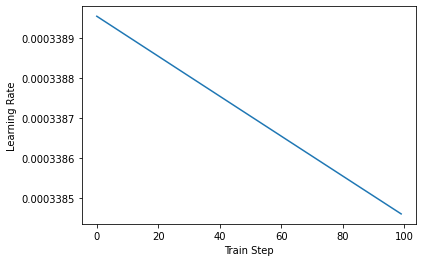

In [ ]:
sample_learning_rate = CustomSchedule2(d_model=256)

plt.plot(sample_learning_rate(tf.range(100, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
# txt 가 쿼리
# img 가 key + value

def txtimg_encoder_layer(dff, d_model, num_heads, dropout, name='imgtxt_encoder_layer'):
  txtInput = Input(shape=(max_len, d_model), name="txtInputs_Query")
  imgInput = Input(shape=(max_len, d_model), name="imgInputs_Key_Value")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (Query : Txt, Key = Value : Image)
  imgAttention = MultiHeadAttention(
    d_model, num_heads, name="img_txt_attention")(inputs={
        'query': txtInput, 'key': imgInput, 'value': imgInput, # Q != K = V
        'mask': padding_mask # 패딩 마스크
    })

  # 잔차 + 정규화
  imgAttention = Dropout(rate=dropout)(imgAttention)
  imgAttention = LayerNormalization(epsilon=1e-6)(imgAttention + txtInput)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = Dense(units=dff, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001))(imgAttention)
  outputs = Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = Dropout(rate=dropout)(outputs)
  outputs = LayerNormalization(epsilon=1e-6)(outputs + imgAttention)

  return tf.keras.Model(inputs=[txtInput, imgInput, padding_mask],
      outputs=outputs,
      name=name)
  


In [ ]:
# txt가 쿼리
# img가 키와 value

def txtimg_encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="txtimg_encoder"):
  txtInput = Input(shape=(max_len, d_model, ), name="txt inputs")
  imgInput = Input(shape=(max_len, d_model, ), name="img inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  outputs = tf.keras.layers.Dropout(rate=dropout)(txtInput)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = txtimg_encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="txtimg_encoder_layer_{}".format(i),
    )([outputs, imgInput ,padding_mask])

  return tf.keras.Model(
      inputs=[txtInput, imgInput, padding_mask], outputs=outputs, name=name)

In [ ]:
# img 가 쿼리
# txt 가 key + value

def imgtxt_encoder_layer(dff, d_model, num_heads, dropout, name='imgtxt_encoder_layer'):
  imgInput = Input(shape=(max_len, d_model), name="imgInputs_Query")
  txtInput = Input(shape=(max_len, d_model), name="txtInputs_KeyValue")

  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (Query : Txt, Key = Value : Image)
  txtAttention = MultiHeadAttention(
    d_model, num_heads, name="img_txt_attention")(inputs={
        'query': imgInput, 'key': txtInput, 'value': txtInput, # Q != K = V
        'mask': padding_mask # 패딩 마스크
    })

  # 잔차 + 정규화
  txtAttention = Dropout(rate=dropout)(txtAttention)
  txtAttention = LayerNormalization(epsilon=1e-6)(txtAttention + imgInput)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = Dense(units=dff, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001))(txtAttention)
  outputs = Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = Dropout(rate=dropout)(outputs)
  outputs = LayerNormalization(epsilon=1e-6)(outputs + txtAttention)

  return tf.keras.Model(inputs=[imgInput, txtInput, padding_mask],
      outputs=outputs,
      name=name)
  


In [ ]:
# img가 쿼리
# txt가 키와 value

def imgtxt_encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="imgtxt_encoder"):
  imgInput = Input(shape=(max_len, d_model,), name="img inputs")
  txtInput = Input(shape=(max_len, d_model,), name="txt inputs")
  # 인코더는 패딩 마스크 사용
  padding_mask = Input(shape=(1, 1, None), name="padding_mask")

  outputs = Dropout(rate=dropout)(imgInput)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = imgtxt_encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="imgtxt_encoder_layer_{}".format(i),
    )([outputs, txtInput ,padding_mask])

  return Model(
      inputs=[imgInput, txtInput, padding_mask], outputs=outputs, name=name)

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
# X는 train_data (image, question, answer)
# batch_size : BATCH_SIZE
# target_size : 이미지 크기
# shuffle : 셔플

class DataGenerator(Sequence):
  def __init__(self, X, tokenizer, vocab_size, batch_size, target_size = (224,224), shuffle = True):
    self.X = X
    self.length = len(X)
    self.batch_size = batch_size
    self.target_size = target_size
    self.shuffle = shuffle
    self.tokenizer = tokenizer
    self.vocab_size = vocab_size
    self.on_epoch_end()
  
  def on_epoch_end(self):
    self.indexes = np.arange(self.length)
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __len__(self):
    return int(np.floor(self.length / self.batch_size))

  def __data_generation(self, i):  
    filepath = './images/' + self.X.iloc[i]['image']
    img = Image.open(filepath)
    img.draft('RGB', (224,224))
    img = img.resize(self.target_size, Image.NEAREST)
    img = np.array(img)
    img = img / 255.0

    tokenized = self.tokenizer.tokenize(self.X.iloc[i]['question'])
    question = self.tokenizer.convert_tokens_to_ids(tokenized)

    self.tokenizer.add_tokens(self.X.iloc[i]['answer'])
    answer = self.tokenizer.convert_tokens_to_ids(self.X.iloc[i]['answer'])

    return img, question, answer

  def __getitem__(self, index):
    img_data = np.empty((0,224,224,3))
    quest_data = []
    ans_data = []
    indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

    for i in indexes:
      img, question, answer = self.__data_generation(i)
      img_data = np.append(img_data, [img], axis=0)
      quest_data.append(question)
      ans_data.append(answer)

    quest_data = sequence.pad_sequences(quest_data, maxlen=max_len, padding='post')
    ans_data = to_categorical(ans_data, num_classes = self.vocab_size)

    return [quest_data, img_data], ans_data

In [ ]:
# X는 train_data (image, question, answer)
# batch_size : BATCH_SIZE
# target_size : 이미지 크기
# shuffle : 셔플

class DataGenerator_test(Sequence):
  def __init__(self, X, tokenizer, vocab_size, batch_size, target_size = (224,224), shuffle = True):
    self.X = X
    self.length = len(X)
    self.batch_size = batch_size
    self.target_size = target_size
    self.shuffle = shuffle
    self.tokenizer = tokenizer
    self.vocab_size = vocab_size
    self.on_epoch_end()
  
  def on_epoch_end(self):
    self.indexes = np.arange(self.length)
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __len__(self):
    return int(np.floor(self.length / self.batch_size))

  def __data_generation(self, i):  
    filepath = './test/images/' + self.X.iloc[i]['image']
    img = Image.open(filepath)
    img.draft('RGB', (224,224))
    img = img.resize(self.target_size, Image.NEAREST)
    img = np.array(img)
    img = img / 255.0

    tokenized = self.tokenizer.tokenize(self.X.iloc[i]['question'])
    question = self.tokenizer.convert_tokens_to_ids(tokenized)

    return img, question

  def __getitem__(self, index):
    img_data = np.empty((0,224,224,3))
    quest_data = []
    indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

    for i in indexes:
      img, question = self.__data_generation(i)
      img_data = np.append(img_data, [img], axis=0)
      quest_data.append(question)

    quest_data = sequence.pad_sequences(quest_data, maxlen=max_len, padding='post')

    return [quest_data, img_data]

###데이터 제너레이터

In [ ]:
train_data = pd.read_csv('./drive/MyDrive/vqa/train.csv')
train_data.drop(['category'], axis=1,inplace=True)

tokenizer = get_tokenizer()

train_data, valid_data, train_y, valid_y = train_test_split(train_data, train_data['answer'], test_size=0.01, random_state=77)

train_generator = DataGenerator(train_data, tokenizer=tokenizer, vocab_size=VOCAB_SIZE, 
                  batch_size=BATCH_SIZE,
                  target_size = (TARGET_SIZE, TARGET_SIZE),
                  shuffle=True)

valid_generator = DataGenerator(valid_data, tokenizer=tokenizer, vocab_size=VOCAB_SIZE, 
                  batch_size=BATCH_SIZE,
                  target_size = (TARGET_SIZE, TARGET_SIZE),
                  shuffle=True)

###모델링


In [ ]:
# 여기서 문장의 길이를 max_len으로 맞춰주자.
txtInput = Input(shape=(max_len, ), name='text_input')
imgInput = Input(shape=(224, 224, 3, ), name='img_input')

padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(txtInput)

# 텍스트 입력 후 Transformer Encoder 통과
# 형태소가 나누어져서 각 단어마다 정수 인코딩이 된 상태라고 가정.(토큰화 완료)
# 사전 훈련된 한국어 임베딩 모델....있나?
# tokenizer은 koBERT의 토크나이저 사용
# 임베딩은 pre-trained를 사용하지 않고 질문에서 학습

embedding_layer = TokenAndPositionEmbedding(max_len, VOCAB_SIZE, d_model)

# text의 각 단어에 512차원의 임베딩완료(임베딩 + 포지션)
txt = embedding_layer(txtInput)

# 멀티헤드어텐션 + FFNN 네트워크, num_layers 만큼 존재
# 입력 : txt : (None, 40, 512)
# 출력 : txtOutput, (None, 40, 512)
txtOutput = encoder(VOCAB_SIZE, num_layers=num_layers, dff=dff, 
                     d_model=d_model, num_heads=num_heads,
                     dropout=dropout)([txt, padding_mask])

# 이미지 입력 후 CNN 통과
# 출력 : imgOutput, (None, 40, 512)
img = Conv2D(64, (3,3), padding='same', name='block1_conv1', activation='relu')(imgInput)
img = Conv2D(64, (3,3), padding='same', name='block1_conv2', activation='relu')(img)
img = MaxPooling2D((4,4), name='block1_pool')(img)
img = Conv2D(128, (3,3), padding='same', name='block2_conv1', activation='relu')(img)
img = Conv2D(128, (3,3), padding='same', name='block2_conv2', activation='relu')(img)
img = MaxPooling2D((4,4), name='block2_pool')(img)
img = Conv2D(256, (3,3), padding='same', name='block3_conv1', activation='relu')(img)
img = Conv2D(256, (3,3), padding='same', name='block3_conv2', activation='relu')(img)
img = MaxPooling2D((4,4), name='block3_pool')(img)
#img = Conv2D(512, (3,3), padding='same', name='block4_conv1', activation='relu')(img)
#img = Conv2D(512, (3,3), padding='same', name='block4_conv2', activation='relu')(img)
#img = MaxPooling2D((4,4), name='block4_pool')(img)
#img = Conv2D(1024, (3,3), padding='same', name='block5_conv1', activation='relu')(img)
#img = Conv2D(1024, (3,3), padding='same', name='block5_conv2', activation='relu')(img)
#img = MaxPooling2D((4,4), name='block5_pool')(img)
img = Flatten()(img)
img = Dense(d_model, activation='relu')(img)

#imgOutput = img
#for i in range(max_len-1):
#  imgOutput = concatenate([imgOutput, img])
#imgOutput = Reshape((max_len,d_model))(imgOutput)
img = Reshape([1, d_model])(img)
ones = tf.ones([1, max_len, 1])
imgOutput = tf.matmul(ones, img)


imgAttention_1 = txtimg_encoder(vocab_size=VOCAB_SIZE, num_layers = num_layers, dff=dff, d_model=d_model, num_heads=num_heads, 
                     dropout=dropout, name="txtimg_encoder_1")([txtOutput, imgOutput, padding_mask])

txtAttention = imgtxt_encoder(vocab_size=VOCAB_SIZE, num_layers = num_layers, dff=dff, d_model=d_model, num_heads=num_heads,
                              dropout=dropout, name="imgtxt_encoder_1")([imgAttention_1, txtOutput, padding_mask])

imgAttention_2 = txtimg_encoder(vocab_size=VOCAB_SIZE, num_layers = num_layers, dff=dff, d_model=d_model, num_heads=num_heads, 
                     dropout=dropout, name="txtimg_encoder_2")([txtAttention, imgAttention_1, padding_mask])
                  
outputs = imgtxt_encoder(vocab_size=VOCAB_SIZE, num_layers = num_layers, dff=dff, d_model=d_model, num_heads=num_heads,
                              dropout=dropout, name="imgtxt_encoder_2")([imgAttention_2, txtAttention, padding_mask])

outputs = Flatten()(outputs)
txtFlat = Flatten()(txtOutput)
imgFlat = Flatten()(imgOutput)
outputs = concatenate([outputs , txtFlat, imgFlat], axis=-1)
# outputs = Flatten()(imgAttention)
outputs = Dropout(dropout)(outputs)
outputs = Dense(VOCAB_SIZE, activation='softmax')(outputs)



model = Model(inputs = [txtInput, imgInput], outputs = outputs)

#learning_rate = CustomSchedule(d_model)
learning_rate = CustomSchedule2(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1 = 0.9, beta_2 = 0.98, epsilon=1e-9)
#optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, nesterov=True, momentum=0.9)
#optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
# 아래는 learning_rate 고정
#optimizer = tf.keras.optimizers.Adam(learning_rate = 0.003, beta_1 = 0.9, beta_2 = 0.98, epsilon=1e-9)

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        img_input[0][0]                  
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 56, 56, 64)   0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [ ]:
model.load_weights('./drive/MyDrive/vqa/8_256_512_10_32_5_encoderlayer_2.h5')

In [ ]:
# text_data : 질문 데이터
# img_data : 이미지 데이터
# answers : 정답 데이터 (인코딩 된)
EPOCHS = 4
history = model.fit(
    x = train_generator, 
    epochs = EPOCHS,
    validation_data = valid_generator,
    workers = 6
    # callbacks = callback_list
)

filename = './8_256_512_10_32_15_encoderlayer_2'
# 파일 이름 형식
# layer(트랜스포머 층 개수)_dmodel(임베딩벡터 크기)_dff(피드포워드신경망크기)_numhead(멀티 헤드 개수)
# _img(conv-maxpooling 층 개수)(한 층당 conv 층개수)_epoch(에포크 횟수)

# 드라이브에 있는 test.csv를 업로드 하고 실행
test_data = pd.read_csv('./drive/MyDrive/vqa/test.csv')
test_generator = DataGenerator_test(test_data, tokenizer=tokenizer, vocab_size=VOCAB_SIZE, 
                  batch_size=1,
                  target_size = (TARGET_SIZE, TARGET_SIZE),
                  shuffle=False)

outputs = model.predict(x = test_generator, workers = 6, verbose = 1)
output = np.argmax(outputs, axis = 1)
test_answer = tokenizer.convert_ids_to_tokens(output)
data = {
    'ID':test_data['ID'],
    'answer':test_answer,
}
submission = pd.DataFrame(data)
submission.set_index('ID',inplace=True)
submission.to_csv(filename + '.csv')
files.download(filename + '.csv')
model.save_weights(filename + '.h5')
files.download(filename + '.h5')

Epoch 1/4
6951/6951 [==============================] - 6880s 978ms/step - loss: 1.0640 - accuracy: 0.6238 - val_loss: 1.0357 - val_accuracy: 0.6239
Epoch 2/4
6951/6951 [==============================] - 6925s 995ms/step - loss: 1.0150 - accuracy: 0.6355 - val_loss: 1.0262 - val_accuracy: 0.6340
Epoch 3/4
6951/6951 [==============================] - 7033s 1s/step - loss: 0.9995 - accuracy: 0.6399 - val_loss: 1.0216 - val_accuracy: 0.6313
Epoch 4/4
22131/22131 [==============================] - 1668s 75ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>